In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

This notebook is a homework problem from ACM118. It is a self-containing demonstration of the method in the paper [Solving PDEs using GP](https://arxiv.org/abs/2103.12959). I hope I will get a good grade.

In [245]:
f=lambda x:np.cos(x[0])+x[1]
g=lambda x:np.sum(x)
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [3]:
def make_points_inside(Nd):
    return 2*np.random.rand(Nd,2)-1

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

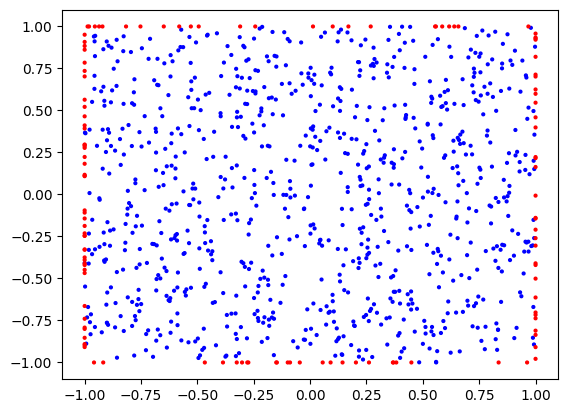

In [178]:
X_int=make_points_inside(900)
X_all=np.concatenate([X_int,make_points_boundary(124)])
plt.scatter(X_all[:,0],X_all[:,1],c=['b']*900+['r']*124,s=4)

# Computing the Laplacians of the kernel

In [97]:
from sympy import symbols, Matrix, exp,diff,simplify

laplacian_1=lambda f:diff(f,x1,x1)+diff(f,x2,x2)
laplacian_2=lambda f:diff(f,y1,y1)+diff(f,y2,y2)
x1,x2,y1,y2,sigma = symbols('x_1 x_2 y_1 y_2 \sigma')
R=symbols('r')
x = Matrix([x1, x2])
y = Matrix([y1, y2])
gauss=exp(-(x-y).dot(x-y)/(2*sigma**2))
gauss

exp((-(x_1 - y_1)**2 - (x_2 - y_2)**2)/(2*\sigma**2))

In [6]:
simplify(laplacian_1(gauss)).subs({(x-y).dot(x-y):R**2})

(-2*\sigma**2 + r**2)*exp(-r**2/(2*\sigma**2))/\sigma**4

In [7]:
simplify(laplacian_2(laplacian_1(gauss))).subs({(x-y).dot(x-y):R**2})

(8*\sigma**4 - \sigma**2*((x1 - y_1)**2 + 5*(x2 - y_2)**2) - \sigma**2*(5*(x1 - y_1)**2 + (x2 - y_2)**2) + (-2*\sigma**2 + r**2)*(x1 - y_1)**2 + (-2*\sigma**2 + r**2)*(x2 - y_2)**2)*exp(-r**2/(2*\sigma**2))/\sigma**8

Further simplifying by hand, we get 
$$\Delta_xk(x,y)=  \frac{1}{\sigma^4}(-2\sigma^2+|x-y|^2 )e^{-\frac{|x-y|^2}{2\sigma^2}}$$
$$\Delta_x\Delta_yk(x,y)=  \frac{1}{\sigma^8}(8\sigma^4-8\sigma^2|x-y|^2+|x-y|^4 )e^{-\frac{|x-y|^2}{2\sigma^2}}$$
with $\sigma=1$
$$\Delta_xk(x,y)=  (|x-y|^2-2 )e^{-\frac{|x-y|^2}{2}}$$
$$\Delta_x\Delta_yk(x,y)=  ((|x-y|^2-4)^2-8 )e^{-\frac{|x-y|^2}{2}}$$

# Computing the kernel matrices

In [259]:
from sklearn.metrics import pairwise_distances

def get_kernel_matrix(X_all,Nd):
    distances=pairwise_distances(X_all)**2
    K11=np.exp(-distances/2)
    K12=-K11[:,:Nd]*(distances[:,:Nd]-2)
    K22=K11[:Nd,:Nd]*((distances[:Nd,:Nd]-4)**2-8)
    return np.block([[K11,K12],[K12.T,K22]])

def get_kernel_vector(x_all,Nd,x):
    distances=pairwise_distances(x_all,Y=x)**2
    K1=np.exp(-distances/2)
    K2=-K1[:Nd]*(distances[:Nd]-2)
    return np.concatenate([K1,K2])


def get_laplacian_kernel_vector(x_all,Nd,x):
    distances=pairwise_distances(x_all,Y=x)**2
    K0=np.exp(-distances/2)
    K1=K0*(distances-2)
    K2=-K0[:Nd]*((distances[:Nd]-4)**2-8)
    return np.concatenate([K1,K2])

K_mat = get_kernel_matrix(X_all,900)+1e-5*np.eye(X_all.shape[0]+900)
L=np.linalg.inv(np.linalg.cholesky(K_mat))


# Setting up Gauss-Newton algorithm

In [186]:
def make_alpha(x_int,x_ext,f,g,tau):
    alpha=lambda z,x,y,t:np.concatenate([z,x,y-t(z)])
    g_vec=np.array([g(x) for x in x_ext])
    f_vec=np.array([f(x) for x in x_int])
    return partial(alpha,x=g_vec,y=f_vec,t=tau)

def differential_matrix(z,N_int,N_ext,dtau):
    return np.block([
        [-np.eye(N_int)],
        [np.zeros((N_ext,N_int))],
        [np.diag(dtau(z))]
    ])


In [218]:
def gauss_newton(x_int,x_ext,f,g,tau,dtau):
    z=np.zeros(x_int.shape[0])
    alpha=make_alpha(x_int,x_ext,f,g,tau)
    dz=3*np.ones_like(z)
    while np.linalg.norm(dz,np.inf)>1e-6:
        H=differential_matrix(z,x_int.shape[0],x_ext.shape[0],dtau)
        target=L@alpha(z)
        mat=L@H
        dz=np.linalg.lstsq(mat,target,rcond=None)[0]
        z+=dz
    
    return alpha(z)
        

# Performing regression

In [249]:
a=gauss_newton(X_int,X_all[900:],f,g,tau,dtau)

In [250]:
u=lambda x:np.dot(L.T@L@a,get_kernel_vector(X_all,900,x))

In [256]:
def plot_vectorized_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig



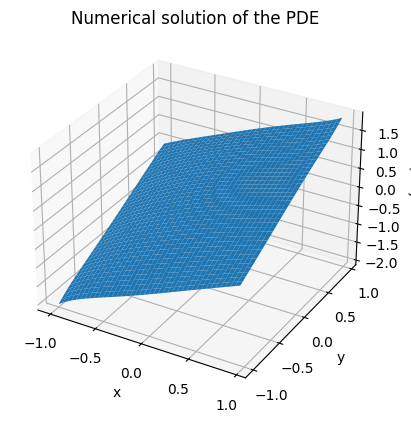

In [251]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

It is difficult to know if the solution is correct. However, we can perform two checks to ensure the fidelity of the method. 
We can plot $u^3-\Delta u$ and verify that it corresponds to $f$
We can solve for a different equation where we prescribe a function and setup $f$ and $g$ so that this function is solution of the PDE. 

We will perform both analyses.

# Plotting $u^3-\Delta u$

In [260]:
u_laplacian=lambda x:np.dot(L.T@L@a,get_laplacian_kernel_vector(X_all,900,x))

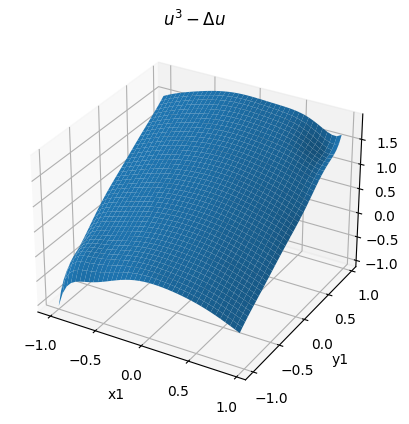

In [261]:
fig=plot_vectorized_function(lambda x:u(x)**3-u_laplacian(x))
plt.title('$u^3-\Delta u$')
plt.show()

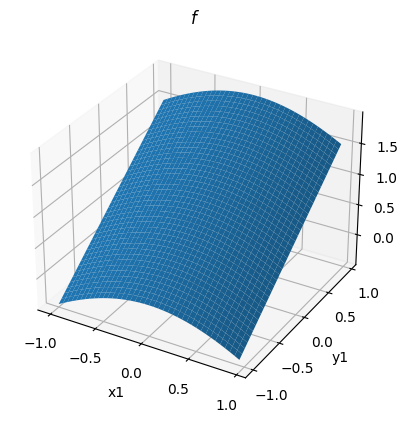

In [262]:
fig=plot_function(f)
plt.title('$f$')
plt.show()

# Plugging in known function
We choose a solution $g=0$ and $u=\cos(\frac{\pi}{2}x)\cos(\frac{\pi}{2}y)$, and we can compute the $f:=-\Delta u+u^3$

In [263]:
from sympy import cos,pi

x,y = symbols('x,y')
test_func=cos(pi/2*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,x,x)
test_f=test_func**3-laplacian(test_func)
test_f

cos(pi*x/2)**3*cos(pi*y/2)**3 + pi**2*cos(pi*x/2)*cos(pi*y/2)/2

In [268]:
u_to_test=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
f_to_test=lambda x:u_to_test(x)*np.pi**2/2+(u_to_test(x))**3
g_to_test=lambda x:0

In [270]:
a_to_test=gauss_newton(X_int,X_all[900:],f_to_test,g_to_test,tau,dtau)
u_to_test_numerical=lambda x:np.dot(L.T@L@a_to_test,get_kernel_vector(X_all,900,x))

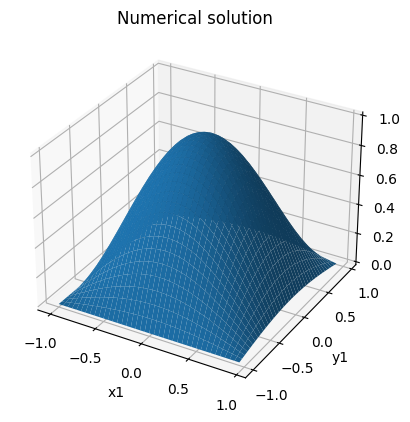

In [273]:
fig=plot_vectorized_function(u_to_test_numerical)
plt.title('Numerical solution')
plt.show()

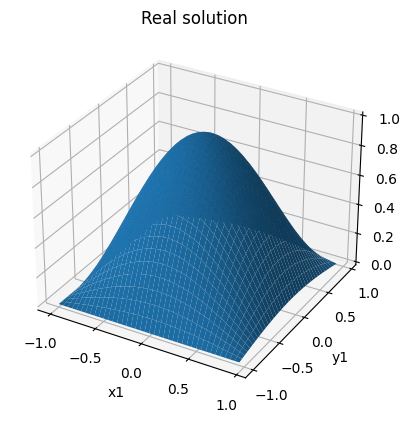

In [274]:
fig=plot_function(u_to_test)
plt.title('Real solution')
plt.show()

In [275]:
x = y = np.arange(-1.0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
U=u_to_test_numerical(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_real = np.array([u_to_test([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
np.linalg.norm(U-U_real,np.inf)

0.000259821373459665

Since the real function is know, we can also compute errors. Here we see that the $L_\infty$ norm is $2.10^{-4}$, which shows that the method indeed works and approximates the real solution.